In [1]:
import jax
import jax.numpy as np

from numpy.polynomial.hermite import hermgauss

from structure_vb_lib import structure_model_lib, posterior_quantities_lib, data_utils, plotting_utils
import structure_vb_lib.structure_optimization_lib as s_optim_lib

from bnpmodeling.sensitivity_lib import HyperparameterSensitivityLinearApproximation
from bnpmodeling.bnp_optimization_lib import optimize_kl
from bnpmodeling import influence_lib, cluster_quantities_lib, result_loading_utils
import bnpmodeling.functional_sensitivity_lib as func_sens_lib

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_public/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp
seed = 98765
onp.random.seed(seed)

# Load data

In [3]:
g_obs, _, labels, _ = data_utils.load_thrush_data()

loading thrush data from : 
../data/thrush_data/thrush-data.str


In [4]:
print(g_obs.shape)

(155, 7, 2, 21)


In [5]:
n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]
n_allele = g_obs.shape[-1]

In [6]:
onp.unique(labels)

array(['Chawia', 'Mbololo', 'Ngangao', 'Yale'], dtype='<U32')

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params(n_allele)

alpha0 = 3.0
prior_params_dict['dp_prior_alpha'] = alpha0

print(prior_params_dict)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

{'dp_prior_alpha': 3.0, 'allele_prior_lambda_vec': DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1.], dtype=float64)}


# Get VB params 

In [8]:
k_approx = 20

In [9]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [10]:
vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs = n_obs,
                                                      n_loci = n_loci,
                                                      n_allele = n_allele, 
                                                      k_approx = k_approx, 
                                                      prng_key = jax.random.PRNGKey(seed))
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_dirichlet_params] = NumericArrayPattern (20, 7, 21) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (155, 19) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (155, 19) (lb=0.0001, ub=inf)


# Load the initial fit

Run the parametric sensitivity note book first, which saves the initial fit

In [11]:
vb_opt_dict, _, init_fit_metadata = \
    paragami.load_folded('./fits/structure_initial_fit.npz')

vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

# optimal z
ez_opt = posterior_quantities_lib.get_optimal_z_from_vb_dict(g_obs, vb_opt_dict, gh_loc, gh_weights)

# check model matches
kl = structure_model_lib.get_kl(g_obs, 
                       vb_opt_dict, 
                       prior_params_dict, 
                       gh_loc, 
                       gh_weights)

assert init_fit_metadata['alpha0'] == alpha0 
assert np.abs(init_fit_metadata['final_kl'] - kl) < 1e-10

# At the optimum, define the sensitivity object

In [12]:
def objective_fun(vb_params_free, epsilon): 
    
    # this actually does not depend on epsilon! 
    # we will set the perturbation later
    
    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    return structure_model_lib.get_kl(g_obs, 
                                      vb_params_dict,
                                      prior_params_dict,
                                      gh_loc, 
                                      gh_weights).squeeze()

In [13]:
# Define the linear sensitivity class
vb_sens = HyperparameterSensitivityLinearApproximation(
                    objective_fun = objective_fun, 
                    opt_par_value = vb_opt, 
                    hyper_par_value0 = np.array([0.]),
                    # null for now. will set later
                    hyper_par_objective_fun = lambda x, y: 0.)


Compiling hessian solver ...
Hessian solver compile time: 73.1733sec

Compiling cross hessian...
Cross-hessian compile time: 0.0546374sec

LR sensitivity time: 0.0387638sec



# Check out the fit

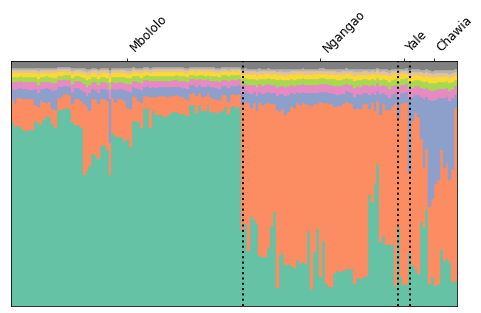

In [14]:
e_ind_admix = posterior_quantities_lib.get_vb_expectations(vb_opt_dict, gh_loc, gh_weights)[0]

# sort everything within populations
perm_obs = data_utils.cluster_admix_get_indx_within_labels(onp.array(e_ind_admix),
                                                               labels)

# now re-order populations: put chawia last
_labels = deepcopy(labels)
_labels[_labels == 'Chawia'] = 'z'
perm_labels = onp.argsort(_labels)
perm_obs = perm_obs[perm_labels]

# plot admixture
fig, ax = plt.subplots(1, 1, figsize = (8, 4.5))

plotting_utils.plot_top_clusters(onp.array(e_ind_admix)[perm_obs], 
                                 ax,
                                 8, 
                                 cmap_colors = plt.get_cmap('Set2').colors);

# print labels
plotting_utils.draw_region_separation(labels[perm_labels], ax);

# Define posterior statistic of interest

In [15]:
def get_e_ind_admix_indx(vb_params_free, n_indx = None): 
    # returns the individual admixtures for a set of individuals in n_indx
    
    # get dictionary
    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    if n_indx is None: 
        n_indx = np.arange(vb_params_dict['ind_admix_params']['stick_means'].shape[0])
    
    # get sticks from these individual 
    stick_means = vb_params_dict['ind_admix_params']['stick_means'][n_indx]
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos'][n_indx]
    
    e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_logitnorm_params(
                        stick_means, 
                        stick_infos,
                        gh_loc,
                        gh_weights)
    
    return e_ind_admix

These are the indices of the outlying individuals

In [16]:
np.argwhere((e_ind_admix[perm_obs][:, 1] > 0.21) & (labels[perm_labels] == 'Mbololo'))

DeviceArray([[25],
             [26],
             [27],
             [28],
             [29],
             [30]], dtype=int64)

In [17]:
np.argwhere((e_ind_admix[perm_obs][:, 0] > 0.4) & (labels[perm_labels] == 'Ngangao'))

DeviceArray([[124],
             [125],
             [126],
             [127]], dtype=int64)

In [18]:
np.argwhere(labels[perm_labels] == 'Chawia')

DeviceArray([[138],
             [139],
             [140],
             [141],
             [142],
             [143],
             [144],
             [145],
             [146],
             [147],
             [148],
             [149],
             [150],
             [151],
             [152],
             [153],
             [154]], dtype=int64)

In [19]:
mbololo_outlier_indx = onp.argwhere((e_ind_admix[:, 1] > 0.21) & (labels == 'Mbololo')).squeeze()
def g_mbololo(vb_params_free): 
    
    # get this individual's admixutre
    admix = get_e_ind_admix_indx(vb_params_free, n_indx = mbololo_outlier_indx)
    
    # posterior statistic of interest: 
    # proportion of "orange" 
    return admix.mean(0)[1] 


chawia_indx = onp.argwhere(labels == 'Chawia').squeeze()
def g_chawia(vb_params_free): 
    
    # get this individual's admixutre
    admix = get_e_ind_admix_indx(vb_params_free, n_indx = chawia_indx)
    
    # posterior statistic of interest: 
    # proportion of "purple" 
    return admix.mean(0)[2]


ngangao_outlier_indx = onp.argwhere((e_ind_admix[:, 0] > 0.4) & (labels == 'Ngangao')).squeeze()
def g_ngangao(vb_params_free): 
    
    # get this individual's admixutre
    admix = get_e_ind_admix_indx(vb_params_free, n_indx = ngangao_outlier_indx)
    
    # posterior statistic of interest: 
    # proportion of "green" 
    return admix.mean(0)[0]



Choose a posterior statistic

In [20]:
post_stat = 'mbololo'

if post_stat == 'mbololo': 
    g = g_mbololo
    outlier_indx = mbololo_outlier_indx
    which_k = 1
elif post_stat == 'chawia': 
    g = g_chawia
    outlier_indx = chawia_indx
    which_k = 2
elif post_stat == 'ngangao': 
    g = g_ngangao
    outlier_indx = ngangao_outlier_indx
    which_k = 0
else: 
    raise NotImplementedError()

In [21]:
g(vb_opt)

DeviceArray(0.24236034, dtype=float64)

# Get influence function

In [22]:
influence_operator = influence_lib.InfluenceOperator(vb_opt, 
                           vb_params_paragami, 
                           vb_sens.hessian_solver,
                           prior_params_dict['dp_prior_alpha'], 
                           stick_key = 'ind_admix_params')

In [23]:
get_grad_g = jax.jit(jax.jacobian(g))
grad_g = get_grad_g(vb_opt).block_until_ready()

In [24]:
logit_v_grid = np.linspace(-6, 6, 100)

In [25]:
# weighted by prior
influence_grid, grad_g_hess_inv = \
    influence_operator.get_influence(logit_v_grid, 
                                     grad_g, 
                                     weight_by_inv_prior = False)


In [26]:
worst_case = influence_lib.WorstCasePerturbation(influence_fun = None, 
                                                 logit_v_grid = logit_v_grid, 
                                                 # negative because we are interested in 
                                                 # downard perturbation
                                                 delta = -1,
                                                 cached_influence_grid = influence_grid)

In [27]:
# set up prior perturbation class for plotting
prior_perturbation_wc = func_sens_lib.PriorPerturbation(
                                    alpha0 = alpha0,
                                    log_phi = worst_case.log_phi, 
                                    logit_v_ub = 10, 
                                    logit_v_lb = -10)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_public/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:276: AccuracyWarning: maxiter (50) exceeded. Latest difference = 8.355877e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_public/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:276: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.502095e-01
  warnings.warn(


In [28]:
def plot_influence_grid(influence_grid, worst_case, ax): 
    
    # plot y = 0 line
    for i in range(2): 
        ax[i].axhline(0, color = 'black')
    
    # plot influence function
    ax[0].plot(logit_v_grid, influence_grid, color = '#43a2ca')
        
    # plot l-inf worst-case perturbation
    wc_log_phi = worst_case.log_phi(logit_v_grid)
    ax[1].plot(logit_v_grid, wc_log_phi, color = 'grey')
    ax[1].fill_between(logit_v_grid, 0, wc_log_phi, color = 'grey', alpha = 0.5)
    
    for cp in worst_case.change_points: 
        ax[0].axvline(cp, color = 'grey', linestyle = 'dashed')
    
    ax[0].set_ylabel('influence')
    ax[1].set_ylabel('worst-case log phi')


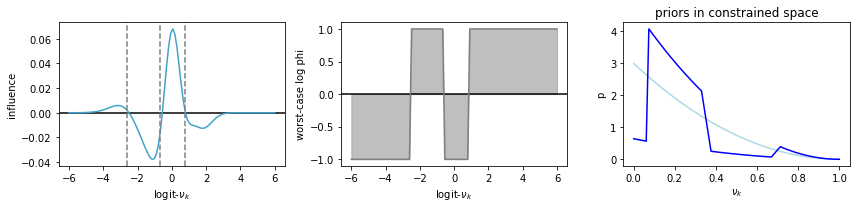

In [29]:
fig, axarr = plt.subplots(1, 3, figsize = (12, 3),  sharex = False) 

plot_influence_grid(influence_grid,
                    worst_case,
                    axarr)

for j in range(3): 
    axarr[j].set_xlabel(r'logit-$\nu_k$')
    
    
# plot perturbed prior 
prior_perturbation_wc._plot_priors_constrained(axarr[-1])

fig.tight_layout()


# Define perturbation

In [30]:
import jax.scipy as sp

In [31]:
f_obj = func_sens_lib.FunctionalPerturbationObjective(worst_case.log_phi, 
                                          vb_params_paragami, 
                                          e_log_phi = lambda x,y : worst_case.get_e_log_linf_perturbation(x,y), 
                                          gh_loc = gh_loc, 
                                          gh_weights = gh_weights, 
                                          stick_key = 'ind_admix_params')

# Get linear response predictions

In [32]:
epsilon_vec = np.linspace(0, 1., 8)**2
print(epsilon_vec)

[0.         0.02040816 0.08163265 0.18367347 0.32653061 0.51020408
 0.73469388 1.        ]


In [33]:
# set LR sensitivity class
vb_sens._set_cross_hess_and_solve(f_obj.hyper_par_objective_fun)

Compiling cross hessian...
Cross-hessian compile time: 0.435995sec

LR sensitivity time: 0.321753sec



In [34]:
hess_solve_time = vb_sens.lr_time

In [35]:
lr_list = []

for epsilon in epsilon_vec: 
        
    # get linear response
    lr_free_params = vb_sens.predict_opt_par_from_hyper_par(epsilon).block_until_ready()
    
    lr_list.append(lr_free_params)


In [36]:
# save lr-results
np.savez('./fits/structure_' + post_stat + '_lr_results', 
         dinput_dhyper = vb_sens.dinput_dhyper, 
         lr_list = onp.array(lr_list))

# Fit for a range of epsilon

In [37]:
def get_loss(vb_params_free, epsilon): 
    
    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    # get perturbation 
    e_log_phi = lambda means, infos : f_obj.e_log_phi_epsilon(means, infos, epsilon)
    
    # now add the dependence on epsilon
    return structure_model_lib.get_kl(g_obs, 
                                      vb_params_dict,
                                      prior_params_dict,
                                      gh_loc, 
                                      gh_weights, 
                                      e_log_phi = e_log_phi).squeeze()

In [38]:
get_fun = jax.jit(get_loss)

get_grad = jax.jit(jax.grad(get_loss, argnums = 0))

def _get_hvp(x, hyper_param0, v):
    return jax.jvp(jax.grad(get_loss, argnums = 0), (x, hyper_param0), (v, 0.))[1]

get_hvp = jax.jit(_get_hvp)

In [39]:
def refit_with_epsilon(epsilon, new_init_dict):
    
    vb_pert_dict, vb_opt_pert, _, optim_time = \
        optimize_kl(lambda x : get_fun(x, epsilon),
                             new_init_dict, 
                             vb_params_paragami, 
                             get_grad = lambda x : get_grad(x, epsilon),
                             get_hvp = lambda x, v: get_hvp(x, epsilon, v),
                             run_lbfgs = False,
                             run_newton = True)                           

    return vb_pert_dict, vb_opt_pert, optim_time

In [40]:
post_stat

'mbololo'

In [41]:
refit_list = []
refit_time_vec = []

new_init_dict = deepcopy(vb_opt_dict)

i = 0
for epsilon in epsilon_vec: 
    
    print('\n################')
    print('re-optimzing with epsilon = ', epsilon)
    print('################')
    
    # refit
    vb_refit_dict, refit_free, optim_time = refit_with_epsilon(epsilon, new_init_dict)
    
    # save free parameters andtiming
    refit_list.append(refit_free)
    refit_time_vec.append(optim_time)
    
    # save results 
    outfile = './fits/structure_fsens_' + post_stat + '_epsilonindx' + str(i)
    print('saving into', outfile)
    paragami.save_folded(outfile, 
                         vb_refit_dict, 
                         vb_params_paragami, 
                         epsilon = epsilon,
                         alpha0 = alpha0)
    
    i += 1
    
refit_time_vec = onp.array(refit_time_vec)




################
re-optimzing with epsilon =  0.0
################
compiling objective and derivatives ... 
done. Compile time: 35.299sec
Running trust-ncg ... 
Newton time: 0.043sec
Newton out:  Optimization terminated successfully.
done. 
saving into ./fits/structure_fsens_mbololo_epsilonindx0

################
re-optimzing with epsilon =  0.02040816326530612
################
compiling objective and derivatives ... 
done. Compile time: 4.479sec
Running trust-ncg ... 
Newton time: 3.782sec
Newton out:  Optimization terminated successfully.
done. 
saving into ./fits/structure_fsens_mbololo_epsilonindx1

################
re-optimzing with epsilon =  0.08163265306122448
################
compiling objective and derivatives ... 
done. Compile time: 4.474sec
Running trust-ncg ... 
Newton time: 4.627sec
Newton out:  Optimization terminated successfully.
done. 
saving into ./fits/structure_fsens_mbololo_epsilonindx2

################
re-optimzing with epsilon =  0.18367346938775508
#########

# plot admixture weights

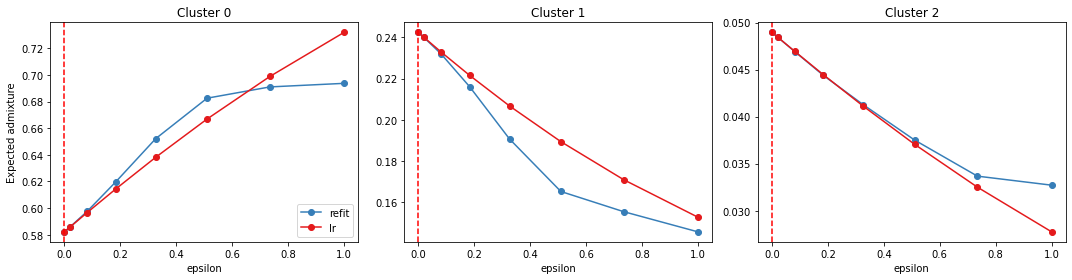

In [42]:
fig, axarr = plt.subplots(1, 3, figsize = (15, 4), sharey = False)

def _weights_fun(x, k): 
    admix = get_e_ind_admix_indx(x, n_indx = outlier_indx)
    
    # make sure it is 2d
    admix = admix.reshape(-1, k_approx)
    
    return admix.mean(0)[k]

# in sample number of clusters
for i in range(3): 
    axarr[i].set_title('Cluster {}'.format(i))
    
    result_loading_utils.plot_post_stat_per_epsilon(lambda x : _weights_fun(x, i),
                                                    refit_list,
                                                    lr_list,
                                                    epsilon_vec, 
                                                    axarr[i])
    
    axarr[i].axvline(0, linestyle = '--', color = 'red')
    
axarr[0].set_ylabel('Expected admixture')
axarr[0].legend()
fig.tight_layout();

# plot inferred structure

In [43]:
def get_inferred_admixture_and_plot(vb_free_params, ax): 
    # get inferred admixture
    e_ind_admix = posterior_quantities_lib.get_vb_expectations(\
                                            vb_params_paragami.fold(vb_free_params, free = True), 
                                            gh_loc,
                                            gh_weights)[0]
    
    # plot admixtures
    plotting_utils.plot_top_clusters(onp.array(e_ind_admix)[perm_obs], 
                                     ax,
                                     8, 
                                     cmap_colors = plt.get_cmap('Set2').colors);

    # print labels 
    plotting_utils.draw_region_separation(labels[perm_labels], ax);
    
    return e_ind_admix[perm_obs]

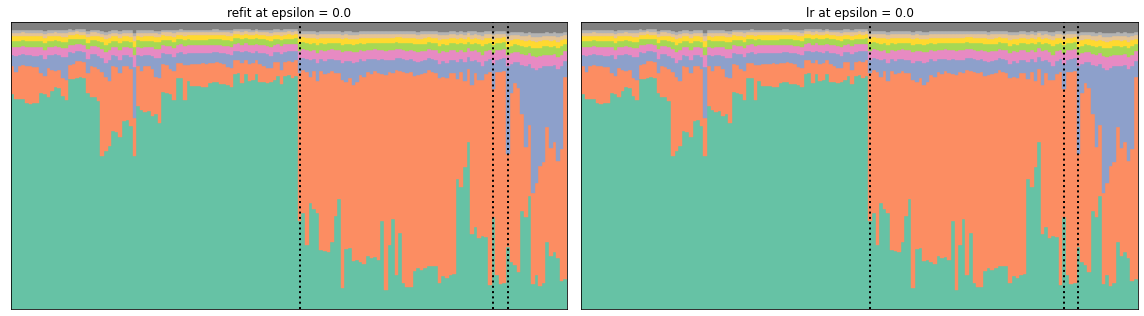

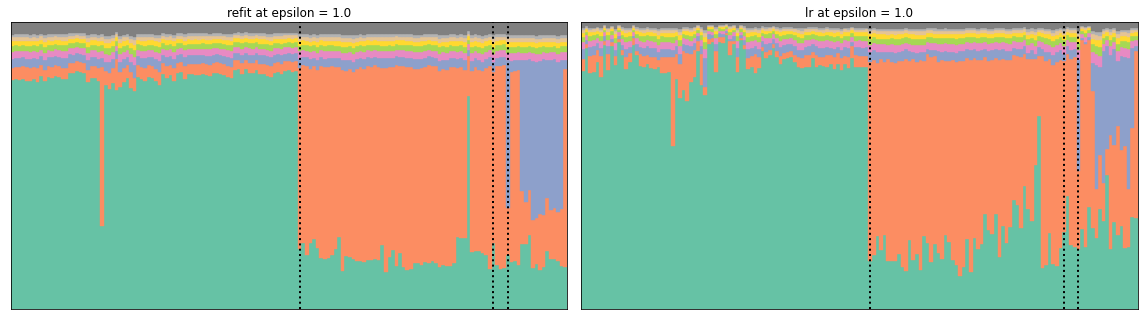

In [44]:
which_epsilons = [0, -1]

admix_lr_list = []
admix_refit_list = []

for i in which_epsilons: 

    fig, ax = plt.subplots(1, 2, figsize = (16, 4.5))
    
    ax[0].set_title('refit at epsilon = {}'.format(epsilon_vec[i]))
    ax[1].set_title('lr at epsilon = {}'.format(epsilon_vec[i]))
    
    # refit
    admix_refit = get_inferred_admixture_and_plot(refit_list[i], ax[0])
    
    # lr 
    admix_lr = get_inferred_admixture_and_plot(lr_list[i], ax[1])
    
    # just remove these labels for now
    for j in range(2): 
        ax[j].set_xticks([]) 

    fig.tight_layout()
    
    
    admix_refit_list.append(admix_refit)
    admix_lr_list.append(admix_lr)